# Project Summary

In this project, I developed a machine learning pipeline to predict interest rates for low-risk loans and optimize lending strategies. Starting from exploratory data analysis (EDA), I identified missing data patterns, feature distributions, and engineered transformations where appropriate. Missing values were handled systematically, and input features were standardized using a StandardScaler.

After establishing a baseline with linear regression — which failed to perform adequately (R² ≈ -5e22%, RMSE ≈ $810M) — I transitioned to XGBoost regression with K-Fold cross-validation for robust model evaluation. The final XGBoost model achieved a mean R² of 30.78% (std 1.58%) and a mean RMSE of 30.32% (std 0.32%), indicating stable and meaningful predictive ability given the noise and complexity of financial loan data. Diagnostics including residual plots and QQ plots confirmed that the model generalized appropriately without major distributional issues or significant overfitting.

Based on the model's risk scores and predicted interest rates, I simulated a lending strategy offering interest rates 0.01 lower than predicted to the safest 5% of borrowers, resulting in a projected additional profit of approximately $860,152.

Key constraints and assumptions of this project include:

- The model was trained only on historical low-risk loan data, assuming past borrower behaviors are predictive of future outcomes.
- No time-based train/test splits were used; random sampling was assumed sufficient due to the lack of explicit temporal features.
- Profitability calculations assumed that the loan amount and risk behavior remain stable under the proposed adjusted interest rates.
- Residual normality was not assumed, as XGBoost is non-parametric and robust to non-normal error structures.

Through this project, I strengthened my practical skills in real-world model validation (early stopping, K-Fold CV), residual diagnostics, scaling transformations, feature engineering, and translating predictive models into business impact. Beyond modeling, I learned the importance of systematically handling assumptions, evaluating model stability across folds, and critically assessing the link between model outputs and real-world business decisions.

In [51]:
import pandas as pd
import numpy as np 
import eda_helpers as eda
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, roc_auc_score, accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import xgboost as xgb

from sklearn.model_selection import KFold

# from sklearn.over_sampling import SMOTE 

from statsmodels.stats.multitest import multipletests
from scipy.stats import ks_2samp, chi2
import math
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Pre-EDA pre-processing 

In [2]:
df = pd.read_csv("/Users/theodora_work/Downloads/loans_full_schema.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 55 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   emp_title                         9167 non-null   object 
 1   emp_length                        9183 non-null   float64
 2   state                             10000 non-null  object 
 3   homeownership                     10000 non-null  object 
 4   annual_income                     10000 non-null  float64
 5   verified_income                   10000 non-null  object 
 6   debt_to_income                    9976 non-null   float64
 7   annual_income_joint               1495 non-null   float64
 8   verification_income_joint         1455 non-null   object 
 9   debt_to_income_joint              1495 non-null   float64
 10  delinq_2y                         10000 non-null  int64  
 11  months_since_last_delinq          4342 non-null   float64
 12  earli

- 10 columns that have some/majority null values
- mix of data types: object and numeric
- there are columns that are created after loan is approved -> dropping them
- for dependent variables, we consider `interest_rate` and `loan_status`

In [3]:
df = df.drop(columns = ['term',
       'installment', 'grade', 'sub_grade', 'issue_month',
       'initial_listing_status', 'disbursement_method',
       'balance', 'paid_total', 'paid_principal', 'paid_interest',
       'paid_late_fees', 'tax_liens'])

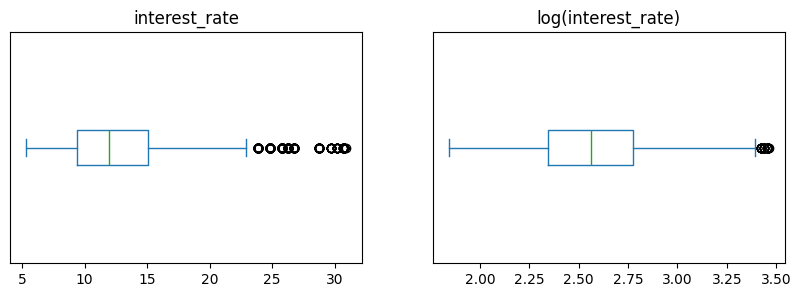

In [4]:
fig, axes = plt.subplots(figsize=(10, 3), ncols=2, nrows=1)
df['interest_rate'].plot.box(vert=False, ax=axes[0])
np.log1p(df['interest_rate']).plot.box(vert=False, ax=axes[1])
axes[0].set_yticks([])
axes[0].set_title('interest_rate')
axes[1].set_yticks([])
axes[1].set_title('log(interest_rate)')
plt.show()

df['interest_rate'] = np.log1p(df['interest_rate'])

`interest_rate` value are left-skewed, treated with log transformation to achieve normality

In [5]:
df['loan_status'].value_counts()

loan_status
Current               9375
Fully Paid             447
In Grace Period         67
Late (31-120 days)      66
Late (16-30 days)       38
Charged Off              7
Name: count, dtype: int64

In [6]:
risky_statuses = [
    "Late (16-30 days)",
    "Late (31-120 days)",
    "Charged Off",
    'In Grace Period'
]

df["is_risky"] = df["loan_status"].isin(risky_statuses)
df.drop(columns = ['loan_status'], inplace = True)

- binary classification chosen to increase number of positive samples
- `is_risky` created for binary classification task, based on `loan_status` values
- to account for the imbalance in the dataset, we will use stratified sampling
- `loan_amount` kept for final analysis

Now, for EDA, let us split the dataset into train and test sets, and then perform EDA on the training set. When actually  training the model, we will use KFold cross-validation to ensure that the model is robust and not overfitting to the training data. 

In [7]:
df.describe().T.sort_index()

,count,mean,std,min,25%,50%,75%,max
account_never_delinq_percent,10000.0,94.648990,9.155059,14.300000,92.600000,100.00000,100.000000,1.000000e+02
accounts_opened_24m,10000.0,4.376100,3.158583,0.000000,2.000000,4.00000,6.000000,2.900000e+01
annual_income,10000.0,79222.148412,64734.290492,0.000000,45000.000000,65000.00000,95000.000000,2.300000e+06
annual_income_joint,1495.0,127914.571244,70168.375404,19200.000000,86833.500000,113000.00000,151545.500000,1.100000e+06
current_accounts_delinq,10000.0,0.000100,0.010000,0.000000,0.000000,0.00000,0.000000,1.000000e+00
current_installment_accounts,10000.0,2.663600,2.935387,0.000000,1.000000,2.00000,3.000000,3.500000e+01
debt_to_income,9976.0,19.308192,15.004851,0.000000,11.057500,17.57000,25.002500,4.690900e+02
debt_to_income_joint,1495.0,19.979304,8.054781,0.320000,14.160000,19.72000,25.500000,3.998000e+01
delinq_2y,10000.0,0.216000,0.683660,0.000000,0.000000,0.00000,0.000000,1.300000e+01
earliest_credit_line,10000.0,2001.290000,7.795510,1963.000000,1997.000000,2003.00000,2006.000000,2.015000e+03


- some columns have all zero values, dropping them 
- columns with different scales, need to be normalized 
- some clearly collinear columns like `annual_income` and `annual_income_joint`, `debt_to_income` and `debt_to_income_joint` will be dropped unless verified.

In [8]:
df = eda.remove_cols_wo_info(df)

In [9]:
df['annual_income'] = df.apply(
    lambda row: max(row['annual_income'], row['annual_income_joint']) 
    if row['verification_income_joint'] in ['Verified', 'Source Verified']
    else row['annual_income'],
    axis=1
)
df['debt_to_income'] = df.apply(
    lambda row: max(row['debt_to_income'], row['debt_to_income_joint']) 
    if row['verification_income_joint'] in ['Verified', 'Source Verified']
    else row['annual_income'],
    axis=1
)

df.drop(columns=['annual_income_joint', 'debt_to_income_joint', 'verification_income_joint'], inplace=True)

In [10]:
df['credit_util_ratio'] = df['total_credit_utilized']/df['total_credit_limit']
df['high_util_flag'] = df['credit_util_ratio'] > 0.9 
df['zero_limit_flag'] = df['total_credit_limit'] == 0
df['has_recent_credit_inquiry'] = df['months_since_last_credit_inquiry'] <= 3 
df['time_since_first_credit'] = 2018 - df['earliest_credit_line']
df['no_deliquency_flag'] = df['account_never_delinq_percent'] == 100
df['avg_credit_limit_per_account'] = df['total_credit_limit']/(df['num_cc_carrying_balance'] + 1)
df['risky_debt_combo'] = (
    ((df['credit_util_ratio'] > 0) & (df['inquiries_last_12m'] > 3))
)
df['low_income_high_limit'] = (
    ((df['annual_income'] < 200000) & (df['total_credit_limit'] > 50000))
)

df["high_inquiry_flag"] = (df["inquiries_last_12m"] > 3).astype(int)
df["recently_delinquent_flag"] = (df["months_since_last_delinq"] <= 12).astype(int)
df["credit_seeking_behavior"] = (
    (df["inquiries_last_12m"] > 2) & (df["months_since_last_credit_inquiry"] < 6)
).astype(int)
df["income_per_account"] = df["annual_income"] / (df["total_credit_lines"] + 1)
df["debt_per_limit"] = df["debt_to_income"] / (df["total_debit_limit"] + 1)
df["open_credit_ratio"] = df["open_credit_lines"] / (df["total_credit_lines"] + 1)
df["utilization_per_account"] = df["total_credit_utilized"] / (df["num_cc_carrying_balance"] + 1)
df["no_recent_inquiry_but_high_util"] = (
    (df["has_recent_credit_inquiry"] == 0) & (df["credit_util_ratio"] > 0.9)
).astype(int)

df["low_income_high_limit"] = (
    (df["annual_income"] < 40000) & (df["total_credit_limit"] > 100000)
).astype(int)

df["discrepant_income_flag"] = (
    (df["verified_income"] == "verified") & (df["annual_income"] < 20000)
).astype(int)
df["credit_age"] = 2025 - pd.to_datetime(df["earliest_credit_line"]).dt.year
df["young_credit_profile_flag"] = (df["credit_age"] <= 2).astype(int)
df["delinq_ratio"] = df["num_historical_failed_to_pay"] / (df["total_credit_lines"] + 1)
df["recent_delinquency_flag"] = (
    (df["months_since_90d_late"] <= 6) | (df["months_since_last_delinq"] <= 6)
).astype(int)


In [11]:
X = df.drop(columns=['interest_rate', 'is_risky', 'loan_amount'])
y = df[['is_risky']]

X_train, X_test, y_train_cls, y_test_cls = train_test_split(
    X, y, 
    test_size=0.1, 
    stratify=y,     
    random_state=42
)

y_train_reg, y_test_reg = df['interest_rate'].iloc[X_train.index], df['interest_rate'].iloc[X_test.index]
print(f"X_train has {X_train.shape[0]} rows X_test has {X_test.shape[0]} rows")
print(f"X_train has positive class: {y_train_cls['is_risky'].sum() / len(y_train_cls):.2%}")
print(f"X_test has positive class: {y_test_cls['is_risky'].sum() / len(y_test_cls):.2%}")    


X_train has 9000 rows X_test has 1000 rows
X_train has positive class: 1.78%
X_test has positive class: 1.80%


# EDA

## numerical columns
- imputing null values with median 
- collinear columns 

In [12]:
cts_df = df.select_dtypes(exclude=['object'])
cts_df.describe().T

,count,mean,std,min,25%,50%,75%,max
emp_length,9183.0,5.930306,3.703734,0.000000,2.000000,6.000000,10.000000,1.000000e+01
annual_income,10000.0,84821.576169,67154.692054,0.000000,50000.000000,70000.000000,101000.000000,2.300000e+06
debt_to_income,9999.0,74232.962551,67339.736743,0.000000,40000.000000,64000.000000,93000.000000,2.300000e+06
delinq_2y,10000.0,0.216000,0.683660,0.000000,0.000000,0.000000,0.000000,1.300000e+01
months_since_last_delinq,4342.0,36.760709,21.634939,1.000000,19.000000,34.000000,53.000000,1.180000e+02
earliest_credit_line,10000.0,2001.290000,7.795510,1963.000000,1997.000000,2003.000000,2006.000000,2.015000e+03
inquiries_last_12m,10000.0,1.958200,2.380130,0.000000,0.000000,1.000000,3.000000,2.900000e+01
total_credit_lines,10000.0,22.679600,11.885439,2.000000,14.000000,21.000000,29.000000,8.700000e+01
open_credit_lines,10000.0,11.404400,5.868280,0.000000,7.000000,10.000000,14.000000,5.100000e+01
total_credit_limit,10000.0,183606.230400,187632.707777,0.000000,51593.750000,114667.000000,267550.000000,3.386034e+06


In [13]:
null_cts_columns = cts_df.columns[cts_df.isnull().sum() > 0]
null_cnt =  df[null_cts_columns].isnull().sum().sort_values(ascending=False)
null_cts_columns = null_cnt.index
null_cnt

months_since_90d_late               7715
months_since_last_delinq            5658
months_since_last_credit_inquiry    1271
emp_length                           817
credit_util_ratio                      2
debt_to_income                         1
debt_per_limit                         1
dtype: int64

months_since_90d_late is_risky
False    7586
True      129
Name: count, dtype: int64
months_since_last_delinq is_risky
False    5555
True      103
Name: count, dtype: int64
months_since_last_credit_inquiry is_risky
False    1257
True       14
Name: count, dtype: int64
emp_length is_risky
False    803
True      14
Name: count, dtype: int64
credit_util_ratio is_risky
True     1
False    1
Name: count, dtype: int64
debt_to_income is_risky
False    1
Name: count, dtype: int64
debt_per_limit is_risky
False    1
Name: count, dtype: int64


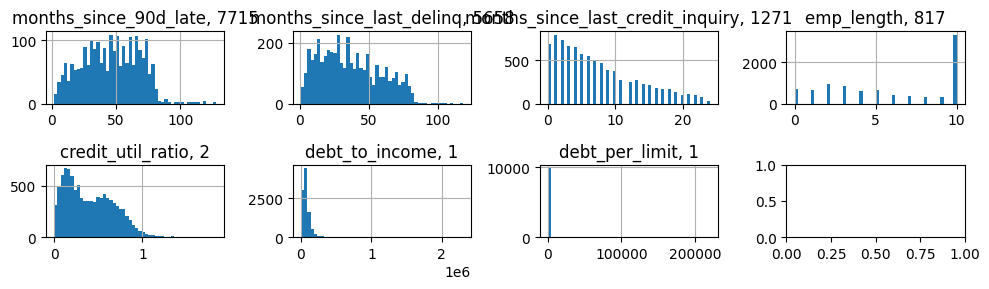

In [14]:
fig, axes = plt.subplots(figsize=(10, 3), ncols=4, nrows=2)
for col, ax in zip(null_cts_columns, axes.flatten()):
    df[col].hist(bins=50, ax=ax)
    ax.set_title(f"{col}, {df[col].isnull().sum()}")
    print(col, df[df[col].isnull()]['is_risky'].value_counts())
fig.tight_layout()
plt.show()

- for columns other than `debt_to_income` and `debt_to_income`, many rows are flagged as risky, so we don't want to drop them. 
- will impute with median values as most columns are skewed or have an extreme outlier. 
- columns with null values > 50%, create a binary variables where info exists or not 

In [15]:
X_train['months_since_90d_late_exists'] = X_train['months_since_90d_late'].notna()
X_train['months_since_last_delinq_exists'] = X_train['months_since_last_delinq'].notna()

imputer = SimpleImputer(strategy='median')
X_train[null_cts_columns] = imputer.fit_transform(X_train[null_cts_columns])
X_train[null_cts_columns].isnull().sum().sort_values(ascending=False)

months_since_90d_late               0
months_since_last_delinq            0
months_since_last_credit_inquiry    0
emp_length                          0
credit_util_ratio                   0
debt_to_income                      0
debt_per_limit                      0
dtype: int64

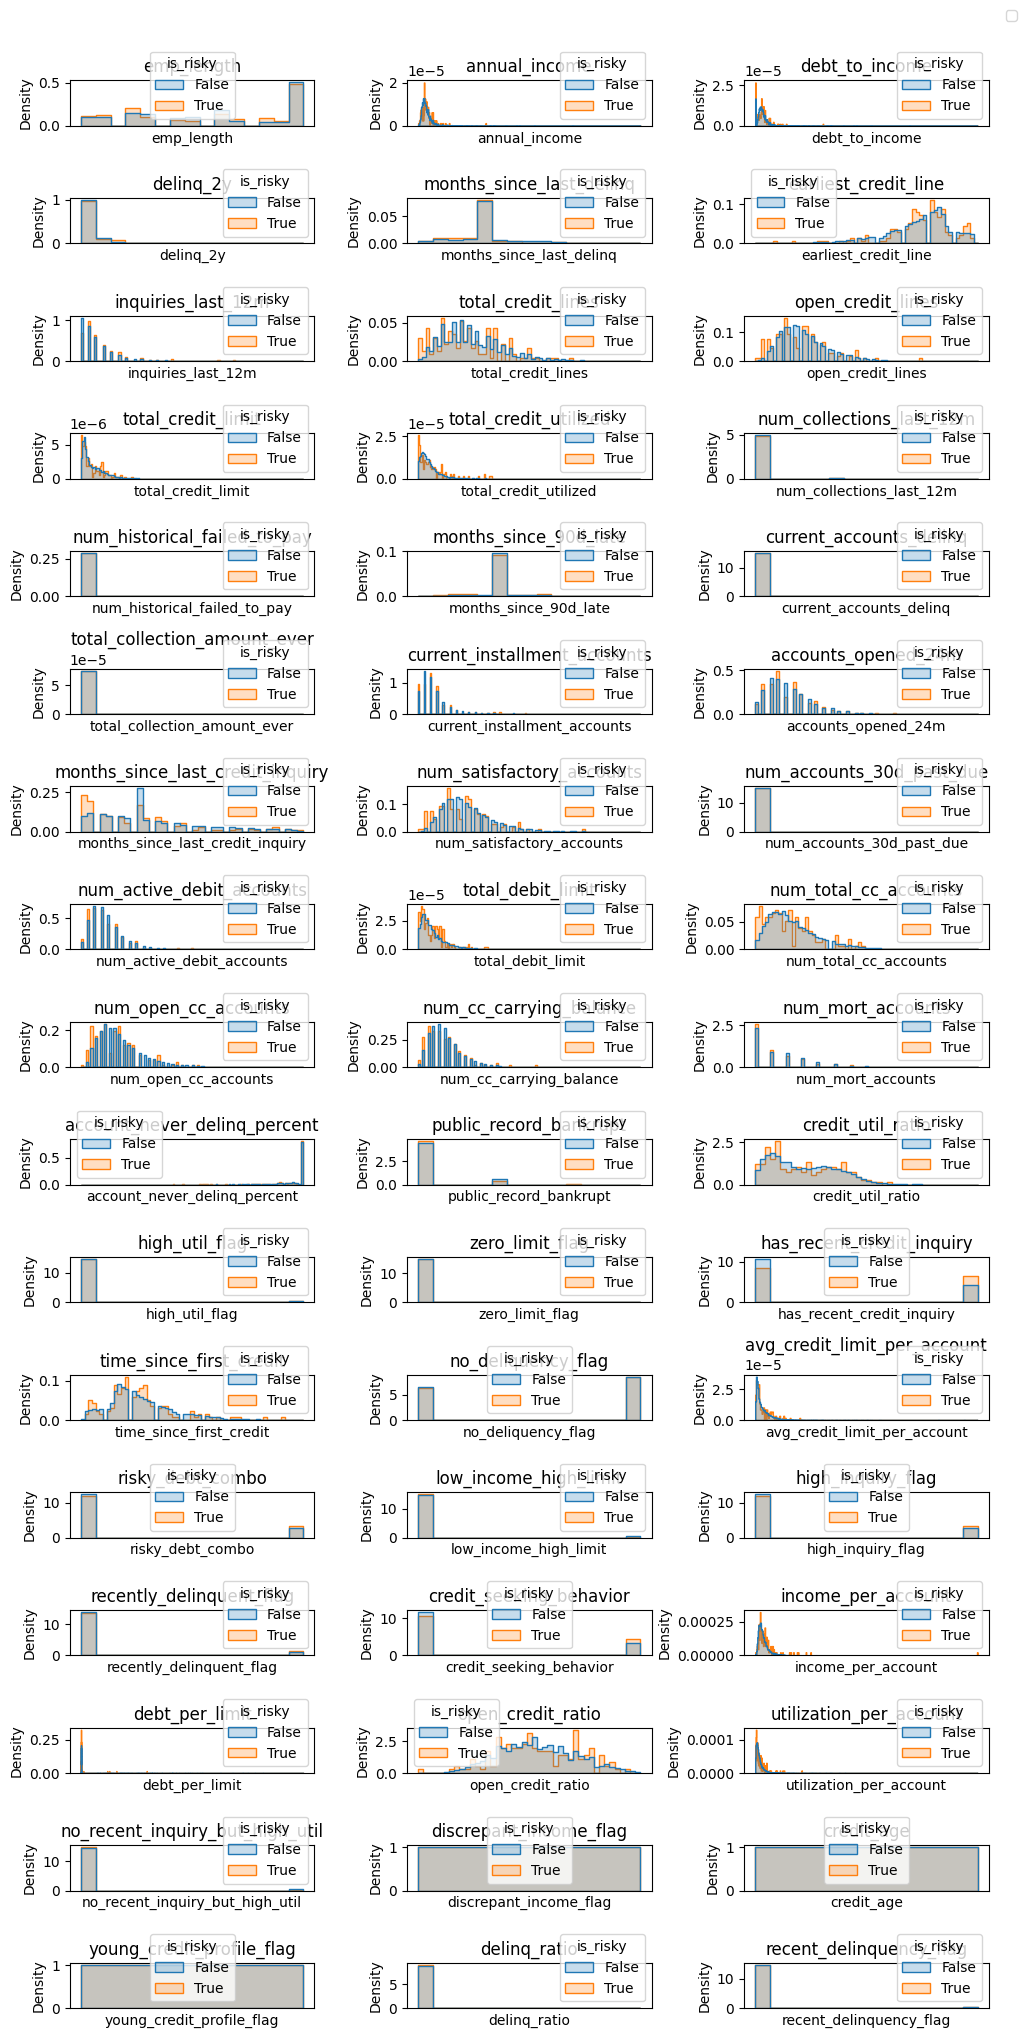

In [16]:
# for classification 
fig, axes = plt.subplots(figsize=(10, 20), ncols=3, nrows=math.ceil((len(cts_df.columns) - 3)/3))
plot_df_cls = pd.concat([X_train, y_train_cls], axis=1)

for col, ax in zip(cts_df.drop(columns=['loan_amount', 'interest_rate', 'is_risky']).columns, axes.flatten()):
    sns.histplot(data=plot_df_cls, x=col, hue='is_risky', element='step', stat='density', common_norm=False, ax=ax)
    ax.set_title(col)
    ax.set_xticks([])
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.02, 1.02))
fig.tight_layout()
fig.show()

- Since most features are highly skewed and display nonlinear, non-Gaussian relationships with our binary target `is_risky`, we consider a tree-based model like XGBoost or Random Forest.

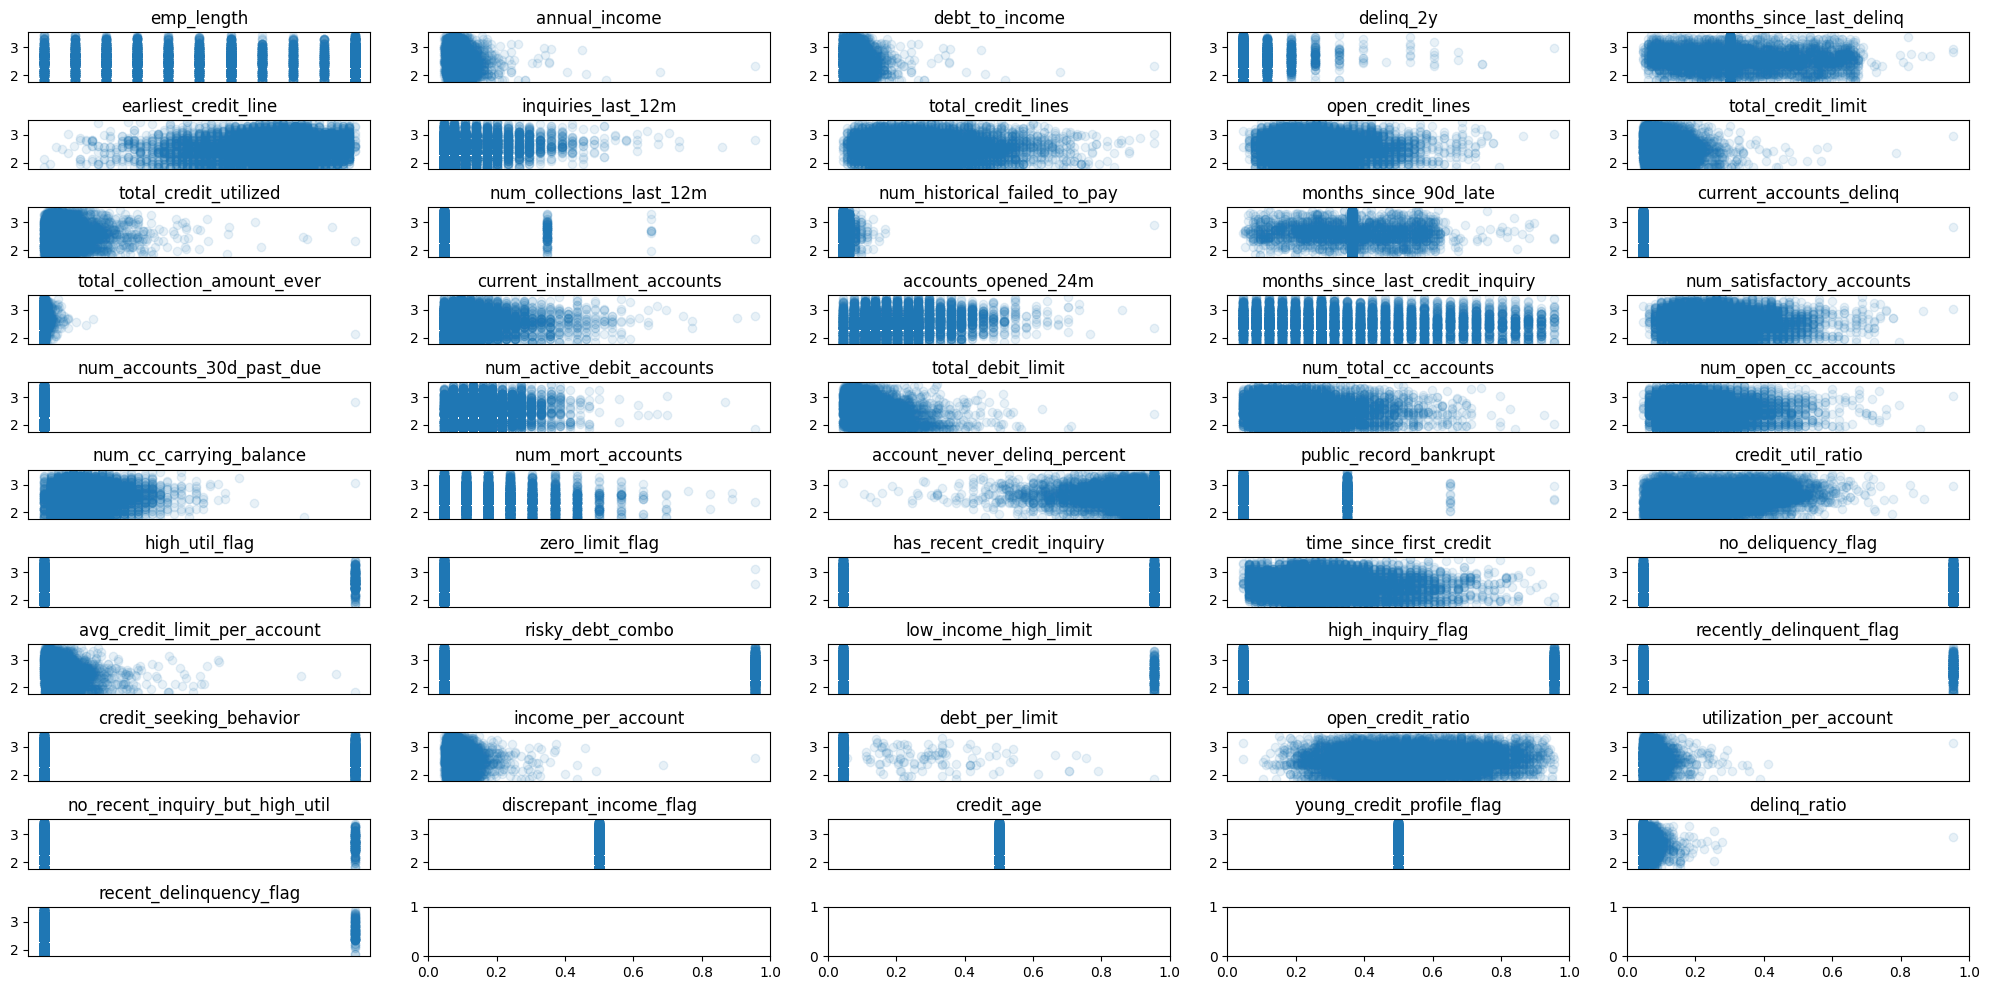

In [17]:
# for regression 
fig, axes = plt.subplots(figsize=(20, 10), ncols=5, nrows=math.ceil((len(cts_df.columns) - 3)/5))
for col, ax in zip(cts_df.drop(columns=['loan_amount', 'interest_rate', 'is_risky']).columns, axes.flatten()):
    ax.scatter(
        X_train[col], 
        y_train_reg, 
        alpha=0.1
    )
    ax.set_title(col)
    ax.set_xticks([])
fig.tight_layout()
fig.show()

- Since we notice clear non-linear relationships between the features and `interest_rate`, we do not consider a linear regression / correlation matrix to be useful. 
- Similar to `is_risky`, we will use a tree-based model to predict `interest_rate` as well.
- We will use KS statistic that accounts for non-normality of non-linear relationship to select features used in the model. 

## categorical columns
- null values filled with `unknown`
- high cardinality columns - take top N (N = 10) categories unless there are too many categories 
- one-hot-encoding categorical columns

In [18]:
cat_df = df.select_dtypes(include=['object'])
for col in cat_df.columns: 
    print(f"{col}: {df[col].nunique()} unique values, {df[col].isna().sum()} null values")

emp_title: 4741 unique values, 833 null values
state: 50 unique values, 0 null values
homeownership: 3 unique values, 0 null values
verified_income: 3 unique values, 0 null values
loan_purpose: 12 unique values, 0 null values
application_type: 2 unique values, 0 null values


In [19]:
X_train['emp_title'] = X_train['emp_title'].fillna('Unknown')

In [20]:
for col in ['emp_title', 'state']: 
    top_n = X_train[col].value_counts().nlargest(10).index
    X_train[col] = X_train[col].where(X_train[col].isin(top_n), 'Other')
X_train['emp_title'].value_counts()

emp_title
Other               7233
Unknown              732
manager              190
owner                184
teacher              181
driver               112
sales                 89
registered nurse      83
rn                    72
supervisor            69
office manager        55
Name: count, dtype: int64

In [21]:
# X_train[cat_df.columns] = OneHotEncoder(drop='if_binary').fit(X_train[cat_df.columns])

In [22]:
encoder = OneHotEncoder(drop='if_binary', sparse_output=False,handle_unknown='ignore')
categorical_cols = cat_df.columns
encoder.fit(X_train[categorical_cols])
X_train_encoded = encoder.transform(X_train[categorical_cols])
encoded_cols = encoder.get_feature_names_out(categorical_cols)
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_cols, index=X_train.index)

In [23]:
encoded_X_train = pd.concat([X_train.drop(columns=categorical_cols), X_train_encoded_df], axis=1)

# Feature selection

In [24]:
cat_columns = encoded_cols
cts_columns = cts_df.columns
cts_columns = list(set(cts_columns) - set(['loan_amount', 'interest_rate', 'is_risky']))
final_train_cls_df = pd.concat([encoded_X_train, y_train_cls], axis=1)
final_train_reg_df = pd.concat([encoded_X_train, y_train_reg], axis=1)

In [25]:
from sklearn.feature_selection import SelectKBest, chi2
def chitest(X, y): 
    chi2_stats, p_values = chi2(X, y)
    return {
        'chi_statistic': chi2_stats[0],
        'p_value': p_values[0]
    }
    
def high_statistic(df, target, column_list, test='ks', stat_cutoff = 0.05, pval_cutoff=0.05): 
    statistic_name = test + '_statistic'
    statistic_info_df = pd.DataFrame(index=column_list, columns =[statistic_name, 'p_value'])
    for col in column_list: 
        if test == 'ks':
            info = eda.ksTest(df, col, target)
            statistic_info_df = statistic_info_df[statistic_info_df[statistic_name] > stat_cutoff]
        elif test == 'chi': 
            info = chitest(df[[col]], df[target])
        statistic_info_df.loc[col] = info
    statistic_info_df = eda.multipletest_adjusted_pvals(statistic_info_df, pval_cutoff)
    return statistic_info_df.sort_values(by=statistic_name, ascending=False)

,ks_statistic,p_value,p_value_adj
income_per_account,0.159813,0.000567,0.015862
has_recent_credit_inquiry,0.141997,0.003154,0.029440
months_since_last_credit_inquiry,0.141997,0.003154,0.029440


,chi_statistic,p_value,p_value_adj
loan_purpose_house,22.273866,0.000002,0.000097


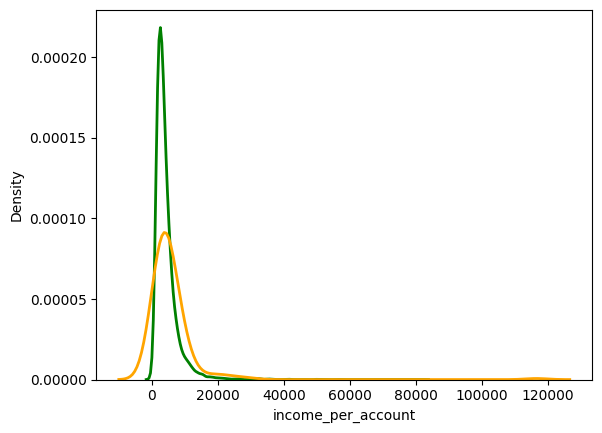

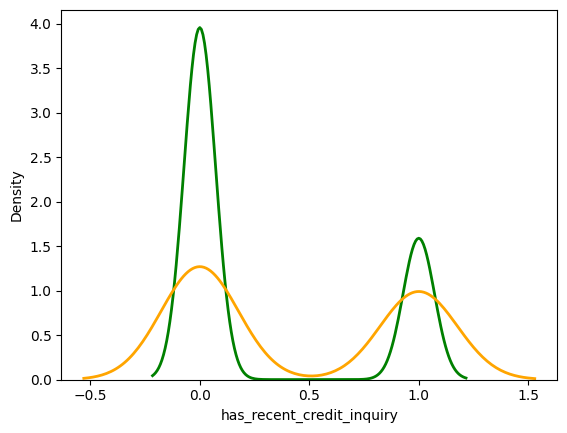

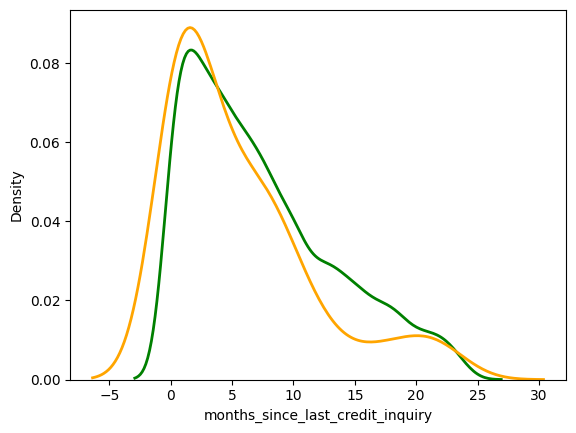

In [26]:
ks_description = high_statistic(final_train_cls_df, 'is_risky', cts_columns)
display(ks_description)
selected_cts_columns = ks_description.index

chi_description = high_statistic(final_train_cls_df, 'is_risky', cat_columns, test='chi')
display(chi_description)
selected_cat_columns = chi_description.index

plot_df = pd.concat([X, y], axis=1)
unique_groups = plot_df['is_risky'].dropna().unique()
for col in selected_cts_columns: 
    for group, color in zip([0, 1], ['green', 'orange']):
        subset = plot_df[plot_df['is_risky'] == group][col].dropna()
        sns.kdeplot(subset, label=f'{'is_risky'} = {group}', linewidth=2, common_norm=True, common_grid=True,color=color)
    plt.show()

- no continuous features selected important for `is_risky` classification
- `loan_purpose_house` selected for `is_risky` classification

In [27]:
from sklearn.feature_selection import mutual_info_regression
mi_scores = mutual_info_regression(encoded_X_train, y_train_reg, random_state=42)

mi_scores = pd.Series(mi_scores, index=encoded_X_train.columns)
mi_scores = mi_scores[mi_scores > 0.01]
mi_scores = mi_scores.sort_values(ascending=False)

print(mi_scores)

total_debit_limit                   0.068281
credit_util_ratio                   0.051935
debt_per_limit                      0.045626
time_since_first_credit             0.026237
total_credit_limit                  0.024719
num_total_cc_accounts               0.023367
num_mort_accounts                   0.023135
high_inquiry_flag                   0.023032
avg_credit_limit_per_account        0.021575
open_credit_ratio                   0.021108
earliest_credit_line                0.020741
inquiries_last_12m                  0.019611
account_never_delinq_percent        0.019077
no_deliquency_flag                  0.018970
verified_income_Verified            0.018448
homeownership_RENT                  0.018099
application_type_joint              0.017946
homeownership_MORTGAGE              0.016225
verified_income_Not Verified        0.016108
accounts_opened_24m                 0.015306
months_since_90d_late               0.014975
months_since_90d_late_exists        0.014782
months_sin

In [28]:
final_X_train_cls = encoded_X_train[['loan_purpose_house', 'months_since_last_credit_inquiry', 'income_per_account']].copy()
final_X_train_reg = encoded_X_train[mi_scores.index].copy()

In [29]:
# encode X_test 
X_test_encoded = encoder.transform(X_test[categorical_cols])
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_cols, index=X_test.index)
encoded_X_test = pd.concat([X_test.drop(columns=categorical_cols), X_test_encoded_df], axis=1)
encoded_X_test[null_cts_columns] = imputer.fit_transform(encoded_X_test[null_cts_columns])
encoded_X_test['months_since_90d_late_exists'] = encoded_X_test['months_since_90d_late'].notna()
encoded_X_test['months_since_last_delinq_exists'] = encoded_X_test['months_since_last_delinq'].notna()
encoded_X_test = encoded_X_test[encoded_X_train.columns]

In [30]:
# scale X_train and use the same scaler to scale X_test
scaler = StandardScaler()
encoded_X_train[cts_columns] = scaler.fit_transform(encoded_X_train[cts_columns])
encoded_X_test[cts_columns] = scaler.transform(encoded_X_test[cts_columns])

# 1. model training - risky classification

In [31]:
# vanilla logistic regression for classification, vanilla linear regression for regression
log_reg = LogisticRegression(
    penalty='l2', 
    C=0.1, 
    solver='liblinear', 
    max_iter=1000, 
    random_state=42
)
log_reg.fit(encoded_X_train, y_train_cls)
y_test_cls_pred = log_reg.predict(encoded_X_test)
print(f"Logistic Classification model - ROC AUC: {roc_auc_score(y_test_cls, y_test_cls_pred):.2%}")

Logistic Classification model - ROC AUC: 50.00%


In [32]:
# random forest for classification

rf_model = RandomForestClassifier(
    n_estimators=300,         # number of trees
    max_depth=None,           # let trees grow fully
    class_weight='balanced',  # important for imbalanced data!
    random_state=42,
    n_jobs=-1                 # use all cores
)

rf_model.fit(encoded_X_train, y_train_cls)

# Predict probabilities
y_pred_rf = rf_model.predict_proba(encoded_X_test)[:, 1]

# Evaluate
roc_auc_rf = roc_auc_score(y_test_cls, y_pred_rf)
print(f"Random Forest ROC AUC: {roc_auc_rf:.4f}")

Random Forest ROC AUC: 0.6998


In [33]:
from xgboost import XGBClassifier
neg = (y_train_cls == 0).sum()['is_risky']
pos = (y_train_cls == 1).sum()['is_risky']
scale = neg / pos

# Train XGBoost
xgb_model = XGBClassifier(
    n_estimators=1000,            # start high, use early stopping
    learning_rate=0.05,           # slower learning
    max_depth=6,                  # tree depth
    scale_pos_weight=scale,       # important for imbalance
    subsample=0.8,                # row sampling
    colsample_bytree=0.8,         # feature sampling
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

xgb_model.fit(
    encoded_X_train, y_train_cls,
    eval_set=[(encoded_X_test, y_test_cls)],
    eval_metric='auc',
    early_stopping_rounds=50,     # stop if no improvement
    verbose=True
)

# Predict probabilities
y_pred_xgb = xgb_model.predict_proba(encoded_X_test)[:, 1]

# Evaluate
roc_auc_xgb = roc_auc_score(y_test_cls, y_pred_xgb)
print(f"XGBoost ROC AUC: {roc_auc_xgb:.4f}")

[0]	validation_0-auc:0.52291
[1]	validation_0-auc:0.51731
[2]	validation_0-auc:0.51327
[3]	validation_0-auc:0.51649
[4]	validation_0-auc:0.49655
[5]	validation_0-auc:0.55089
[6]	validation_0-auc:0.54543
[7]	validation_0-auc:0.57128
[8]	validation_0-auc:0.56291
[9]	validation_0-auc:0.58090
[10]	validation_0-auc:0.60670
[11]	validation_0-auc:0.59753
[12]	validation_0-auc:0.59063
[13]	validation_0-auc:0.61258
[14]	validation_0-auc:0.61496
[15]	validation_0-auc:0.61943
[16]	validation_0-auc:0.60155
[17]	validation_0-auc:0.61518
[18]	validation_0-auc:0.61343
[19]	validation_0-auc:0.61547
[20]	validation_0-auc:0.61162
[21]	validation_0-auc:0.61773
[22]	validation_0-auc:0.61094
[23]	validation_0-auc:0.59827
[24]	validation_0-auc:0.60958
[25]	validation_0-auc:0.61049
[26]	validation_0-auc:0.60947
[27]	validation_0-auc:0.60511
[28]	validation_0-auc:0.59883
[29]	validation_0-auc:0.59363
[30]	validation_0-auc:0.60398
[31]	validation_0-auc:0.60081
[32]	validation_0-auc:0.60410
[33]	validation_0-au

# 2. model training - interest rate prediction

- fun idead: use 'is_risky' as a feature in the model as well

In [34]:
encoded_X_train['risk_score'] = xgb_model.predict_proba(encoded_X_train)[:, 1]
encoded_X_test['risk_score'] = xgb_model.predict_proba(encoded_X_test)[:, 1]

threshold = 0.5
encoded_X_train_safe = encoded_X_train[encoded_X_train['risk_score'] < threshold]
encoded_X_test_safe = encoded_X_test[encoded_X_test['risk_score'] < threshold]
y_train_reg_safe = y_train_reg[encoded_X_train['risk_score'] < threshold]
y_test_reg_safe = y_test_reg[encoded_X_test['risk_score'] < threshold]

In [35]:
# baseline linear regression model 
linregModel = LinearRegression()
linregModel.fit(encoded_X_train_safe, y_train_reg_safe)
y_test_reg_pred = linregModel.predict(encoded_X_test_safe)
print(f"Linear Regression model - R2: {r2_score(y_test_reg_safe, y_test_reg_pred):.2%}")
print(f"Linear Regression model - RMSE: {mean_squared_error(y_test_reg_safe, y_test_reg_pred, squared=False):.2%}")
print(f"Linear Regression model - MAE: {mean_absolute_error(y_test_reg_safe, y_test_reg_pred):.4f}")

Linear Regression model - R2: -50323641608356474388480.00%
Linear Regression model - RMSE: 810549126400.31%
Linear Regression model - MAE: 5452339515.5060


In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Initialize model
rf_reg = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# 2. Fit model
rf_reg.fit(encoded_X_train_safe, y_train_reg_safe)

# 3. Predict
y_pred_rf = rf_reg.predict(encoded_X_test_safe)

print(f"Random Forest Regressor - R2: {r2_score(y_test_reg_safe, y_pred_rf):.2%}")
print(f"Random Forest Regressor - RMSE: {mean_squared_error(y_test_reg_safe, y_pred_rf, squared=False):.2%}")
print(f"Random Forest Regressor - MAE: {mean_absolute_error(y_test_reg_safe, y_pred_rf):.4f}")

Random Forest Regressor - R2: 29.49%
Random Forest Regressor - RMSE: 30.34%
Random Forest Regressor - MAE: 0.2424


In [37]:
from xgboost import XGBRegressor

# 1. Initialize model
xgb_reg = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# 2. Fit model with early stopping
xgb_reg.fit(
    encoded_X_train_safe, y_train_reg_safe,
    eval_set=[(encoded_X_test_safe, y_test_reg_safe)],
    eval_metric='rmse',
    early_stopping_rounds=50,
    verbose=True
)

# 3. Predict
y_pred_xgb = xgb_reg.predict(encoded_X_test_safe)

print(f"XGBoost Regressor - R2: {r2_score(y_test_reg_safe, y_pred_xgb):.2%}")
print(f"XGBoost Regressor - RMSE: {mean_squared_error(y_test_reg_safe, y_pred_xgb, squared=False):.2%}")
print(f"XGBoost Regressor - MAE: {mean_absolute_error(y_test_reg_safe, y_pred_xgb):.4f}")

# 2. Set up K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 3. Prepare to collect results
r2_scores = []
rmse_scores = []
mae_scores = []

# 4. K-Fold Cross-Validation Loop
for fold, (train_idx, val_idx) in enumerate(kf.split(encoded_X_train_safe)):
    print(f"\n=== Fold {fold+1} ===")
    
    X_train_cv, X_val_cv = encoded_X_train_safe.iloc[train_idx], encoded_X_train_safe.iloc[val_idx]
    y_train_cv, y_val_cv = y_train_reg_safe.iloc[train_idx], y_train_reg_safe.iloc[val_idx]

    # Train model with early stopping on validation fold
    xgb_reg.fit(
        X_train_cv, y_train_cv,
        eval_set=[(X_train_cv, y_train_cv), (X_val_cv, y_val_cv)],
        eval_metric='rmse',
        early_stopping_rounds=50,
        verbose=False
    )

    # Predict on validation fold
    y_pred_cv = xgb_reg.predict(X_val_cv)

    # Evaluate
    r2 = r2_score(y_val_cv, y_pred_cv)
    rmse = mean_squared_error(y_val_cv, y_pred_cv, squared=False)
    mae = mean_absolute_error(y_val_cv, y_pred_cv)

    print(f"R2: {r2:.2%}, RMSE: {rmse:.2%}, MAE: {mae:.4f}")

    r2_scores.append(r2)
    rmse_scores.append(rmse)
    mae_scores.append(mae)

# 5. Report Average Results
print("\n=== Cross-Validation Summary ===")
print(f"Mean R2: {np.mean(r2_scores):.2%} (std: {np.std(r2_scores):.2%})")
print(f"Mean RMSE: {np.mean(rmse_scores):.2%} (std: {np.std(rmse_scores):.2%})")
print(f"Mean MAE: {np.mean(mae_scores):.4f} (std: {np.std(mae_scores):.4f})")

[0]	validation_0-rmse:0.35807
[1]	validation_0-rmse:0.35416
[2]	validation_0-rmse:0.35126
[3]	validation_0-rmse:0.34921
[4]	validation_0-rmse:0.34667
[5]	validation_0-rmse:0.34382
[6]	validation_0-rmse:0.34112
[7]	validation_0-rmse:0.33873
[8]	validation_0-rmse:0.33665
[9]	validation_0-rmse:0.33468
[10]	validation_0-rmse:0.33228
[11]	validation_0-rmse:0.33025
[12]	validation_0-rmse:0.32841
[13]	validation_0-rmse:0.32648
[14]	validation_0-rmse:0.32475
[15]	validation_0-rmse:0.32339
[16]	validation_0-rmse:0.32155
[17]	validation_0-rmse:0.32027
[18]	validation_0-rmse:0.31903
[19]	validation_0-rmse:0.31798
[20]	validation_0-rmse:0.31694
[21]	validation_0-rmse:0.31609
[22]	validation_0-rmse:0.31509
[23]	validation_0-rmse:0.31429
[24]	validation_0-rmse:0.31358
[25]	validation_0-rmse:0.31317
[26]	validation_0-rmse:0.31243
[27]	validation_0-rmse:0.31176
[28]	validation_0-rmse:0.31129
[29]	validation_0-rmse:0.31064
[30]	validation_0-rmse:0.31027
[31]	validation_0-rmse:0.30974
[32]	validation_0-

- When restricting to predicted low-risk loans (risk score < 0.5), model performance improves substantially, suggesting that interest rates among safer borrowers are more stable and predictable.
- Your MAE is small but RMSE is large → meaning outliers are hurting your RMSE and R² -> winsorize y outliers
- consider more difficult models like GAM

## diagnosis 1. interpretability

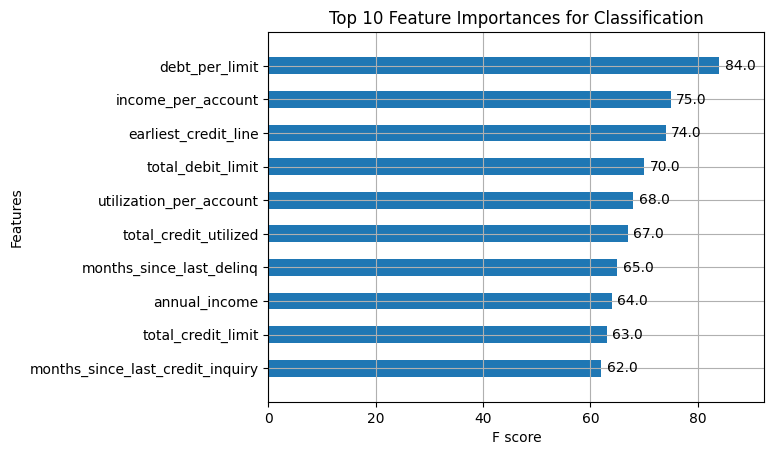

In [38]:
xgb.plot_importance(xgb_model, max_num_features=10, height=0.5)
plt.title('Top 10 Feature Importances for Classification')
plt.show()

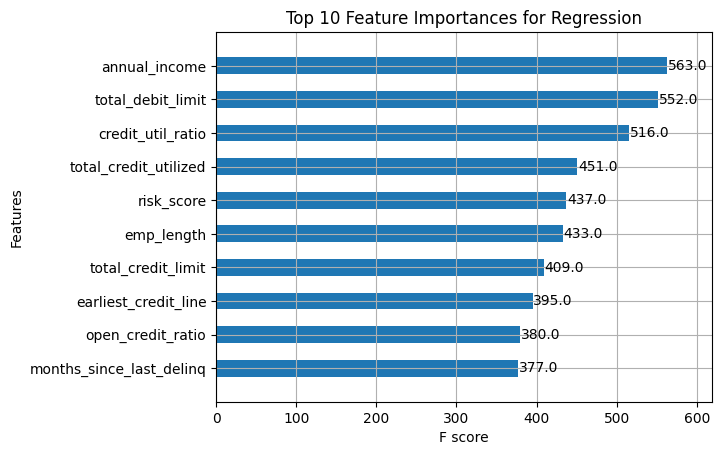

In [39]:
xgb.plot_importance(xgb_reg, max_num_features=10, height=0.5)
plt.title('Top 10 Feature Importances for Regression')
plt.show()

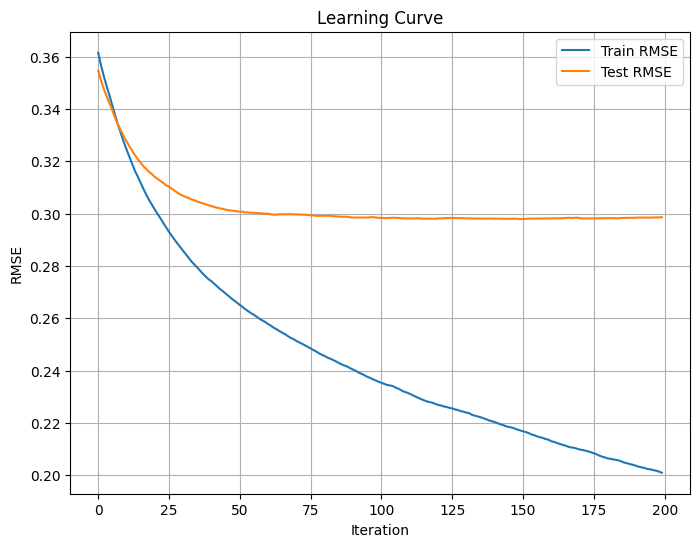

In [40]:
results = xgb_reg.evals_result()

# Plot training vs validation
plt.figure(figsize=(8,6))
plt.plot(results['validation_0']['rmse'], label='Train RMSE')
plt.plot(results['validation_1']['rmse'], label='Test RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

## diagnostic plots

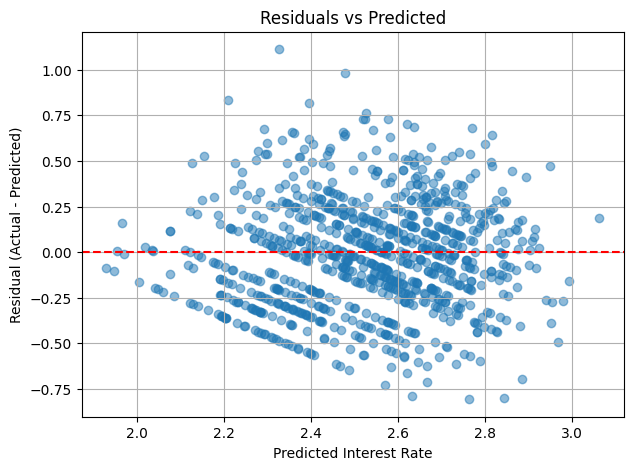

In [41]:
residuals = y_test_reg_safe - y_pred_xgb

plt.figure(figsize=(7,5))
plt.scatter(y_pred_xgb, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Interest Rate')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residuals vs Predicted')
plt.grid(True)
plt.show()


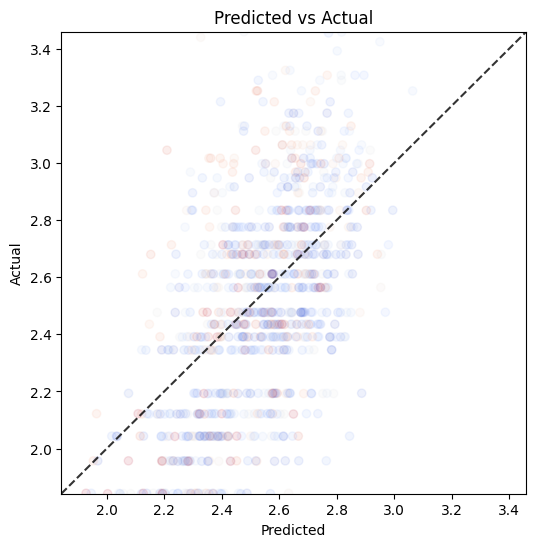

In [42]:
plt.figure(figsize=(6,6))
plt.scatter(y_pred_xgb, y_test_reg_safe, alpha=0.1,
                c=df.iloc[encoded_X_test_safe.index]['loan_amount'], 
    cmap='coolwarm')

# Plot y = x line
lims = [np.min([y_pred_xgb, y_test_reg_safe]), np.max([y_pred_xgb, y_test_reg_safe])]

plt.plot(lims, lims, 'k--', alpha=0.8)  # dashed black line
plt.xlim(lims)
plt.ylim(lims)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Predicted vs Actual')
plt.show()

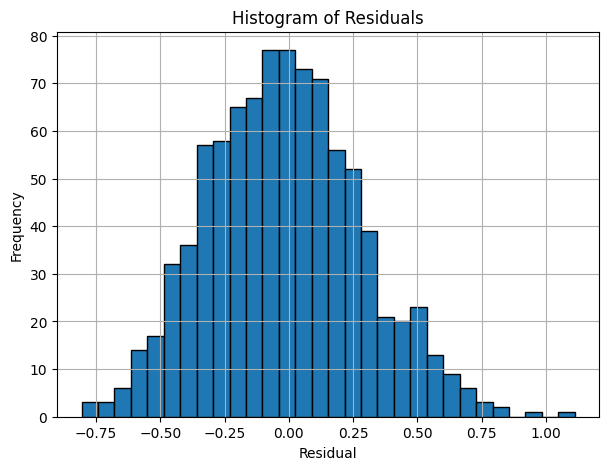

In [43]:
plt.figure(figsize=(7,5))
plt.hist(residuals, bins=30, edgecolor='k')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.grid(True)
plt.show()


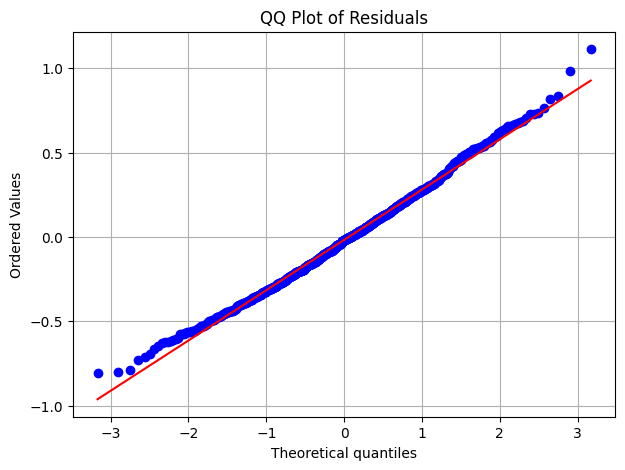

In [44]:
import scipy.stats as stats

plt.figure(figsize=(7,5))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
plt.grid(True)
plt.show()


Since XGBoost is a non-parametric tree-based method, it does not assume normality of residuals. However, the residual QQ plot suggests that the errors are reasonably well-behaved and roughly symmetric, which supports the stability of the model predictions

# 3. Model Diagnosis & Tuning

## improvement 1. y-clipping

In [45]:
lower_clip = y_train_reg_safe.quantile(0.05)
upper_clip = y_train_reg_safe.quantile(0.95)

y_train_reg_safe_clipped = y_train_reg_safe.clip(lower=lower_clip, upper=upper_clip)

In [46]:
from xgboost import XGBRegressor

# 1. Initialize model
xgb_reg = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# 2. Fit model with early stopping
xgb_reg.fit(
    encoded_X_train_safe, y_train_reg_safe_clipped,
    eval_set=[(encoded_X_test_safe, y_test_reg_safe)],
    eval_metric='rmse',
    early_stopping_rounds=50,
    verbose=True
)

# 3. Predict
y_pred_xgb = xgb_reg.predict(encoded_X_test_safe)

print(f"XGBoost Regressor - R2: {r2_score(y_test_reg_safe, y_pred_xgb):.2%}")
print(f"XGBoost Regressor - RMSE: {mean_squared_error(y_test_reg_safe, y_pred_xgb, squared=False):.2%}")
print(f"XGBoost Regressor - MAE: {mean_absolute_error(y_test_reg_safe, y_pred_xgb):.4f}")


[0]	validation_0-rmse:0.35832
[1]	validation_0-rmse:0.35494
[2]	validation_0-rmse:0.35221
[3]	validation_0-rmse:0.34974
[4]	validation_0-rmse:0.34713
[5]	validation_0-rmse:0.34443
[6]	validation_0-rmse:0.34192
[7]	validation_0-rmse:0.33945
[8]	validation_0-rmse:0.33732
[9]	validation_0-rmse:0.33533
[10]	validation_0-rmse:0.33311
[11]	validation_0-rmse:0.33120
[12]	validation_0-rmse:0.32935
[13]	validation_0-rmse:0.32775
[14]	validation_0-rmse:0.32606
[15]	validation_0-rmse:0.32458
[16]	validation_0-rmse:0.32307
[17]	validation_0-rmse:0.32185
[18]	validation_0-rmse:0.32042
[19]	validation_0-rmse:0.31933
[20]	validation_0-rmse:0.31826
[21]	validation_0-rmse:0.31738
[22]	validation_0-rmse:0.31614
[23]	validation_0-rmse:0.31524
[24]	validation_0-rmse:0.31421
[25]	validation_0-rmse:0.31376
[26]	validation_0-rmse:0.31291
[27]	validation_0-rmse:0.31209
[28]	validation_0-rmse:0.31157
[29]	validation_0-rmse:0.31104
[30]	validation_0-rmse:0.31059
[31]	validation_0-rmse:0.30988
[32]	validation_0-

## improvement 2. hyperparameter tuning for XGBoost
- senstitive to hyperparameters
- simple random search

In [47]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

param_dist = {
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6, 8],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_dist,
    n_iter=30,                      # Try 30 random combinations
    scoring=make_scorer(r2_score),   # Optimize for R² directly
    cv=3,                            # 3-fold cross validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(encoded_X_train_safe, y_train_reg_safe_clipped)

print("Best parameters:", random_search.best_params_)
print("Best R2 Score during CV:", random_search.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters: {'subsample': 0.6, 'min_child_weight': 7, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Best R2 Score during CV: 0.3185292926742525


# 4. Final Result: Revenue Calculation

In [48]:
# top 10 safest 
top_5perct = math.ceil(encoded_X_test_safe.shape[0] * 0.05)

analysis_df = pd.DataFrame({
    'risk_score': encoded_X_test_safe['risk_score'].copy(),
    'predicted_interest_rate': y_pred_xgb,
    'actual_interest_rate': y_test_reg_safe
})
analysis_df['adjusted_interest_rate'] = analysis_df['predicted_interest_rate'] - 0.01
analysis_df['loan_amount'] = df.iloc[analysis_df.index]['loan_amount']
analysis_df['is_risky'] = df.iloc[analysis_df.index]['is_risky']
analysis_df['lower_rate'] = analysis_df['adjusted_interest_rate'] < analysis_df['actual_interest_rate']
analysis_df['profit'] = analysis_df['adjusted_interest_rate'] * analysis_df['loan_amount'] * analysis_df['lower_rate'] * (1 - analysis_df['is_risky'])
analysis_df['loss'] = analysis_df['adjusted_interest_rate'] * analysis_df['loan_amount'] * analysis_df['lower_rate'] * analysis_df['is_risky']
analysis_df['final_revenue'] = analysis_df['profit'] - analysis_df['loss'] 
safest_loans = analysis_df.loc[analysis_df['risk_score'].sort_values(ascending=True).head(top_5perct).index]

In [49]:
safest_loans['final_revenue'].sum()

860151.9743651152

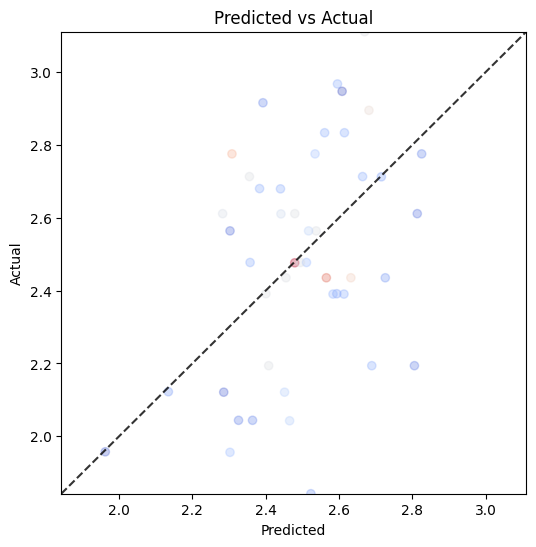

In [50]:
plt.figure(figsize=(6,6))
plt.scatter(    safest_loans['predicted_interest_rate'], 
    safest_loans['actual_interest_rate'], c = safest_loans['loan_amount'], cmap = 'coolwarm'
, alpha=0.3)
# Plot y = x line
lims = [np.min([    safest_loans['predicted_interest_rate'], 
    safest_loans['actual_interest_rate']
]), np.max([    safest_loans['predicted_interest_rate'], 
    safest_loans['actual_interest_rate']
])]

plt.plot(lims, lims, 'k--', alpha=0.8)  # dashed black line
plt.xlim(lims)
plt.ylim(lims)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Predicted vs Actual')
plt.show()